In [1]:
#IMPORT SOME BASIC LIBRARIES 
import requests
import json
import torch
import os
from tqdm import tqdm

from pathlib import Path
from torch.utils.data import DataLoader
import time

In [2]:
#Data load 
with open(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/random_testing/catalyst/cat_full_153.json", "r") as read_file:
    full = json.load(read_file)

In [3]:
print("length of data :", len(full))

length of data : 153


In [83]:
#Split the data into three categories
from sklearn.model_selection import train_test_split

train, _ = train_test_split(full, test_size=0.30, random_state=42)
valid, test = train_test_split(_, test_size=0.50, random_state=42)

In [5]:
#Shape of subdata 
len(train), len(valid), len(test)

(107, 23, 23)

In [6]:
#Read the dataa and foramting the data 
def read_data(squad):
    
    contexts = []
    questions = []
    answers = []

    for group in squad:
    # for passage in group['paragraphs']:
        context = group['context']
        for qa in group['qas']:
            question = qa['question']
            for answer in qa['answers']:
                contexts.append(context)
                questions.append(question)
                answers.append(answer)

    return contexts, questions, answers

#Call the functions
train_contexts, train_questions, train_answers = read_data(train)
valid_contexts, valid_questions, valid_answers = read_data(valid)
test_contexts, test_questions, test_answers = read_data(test)

In [7]:
#Actual data points
print("shape of train:>>", len(train_contexts))
print("shape of valid:>>", len(valid_contexts))
print("shape of test:>>", len(test_contexts))

shape of train:>> 2136
shape of valid:>> 476
shape of test:>> 412


In [10]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two so we fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters
        else:
            answer['answer_end'] = end_idx

add_end_idx(train_answers, train_contexts)
add_end_idx(valid_answers, valid_contexts)
add_end_idx(test_answers, test_contexts)

In [14]:
# You can see that now we get the answer_end also
print("Question example:",train_questions[-10], "\n")
print("Answer example same index:",train_answers[-10], "\n")
print("Context for question and answer::",train_contexts[-10], "\n")

Question example: What are the materials used as catalyst? 

Answer example same index: {'text': 'Ru', 'answer_start': 497, 'answer_end': 499} 

Context for question and answer:: Polymers are extensively used as supports for the fabrication of catalysts. They have many advantages such as high thermal stability, ease of modification, high mechanical strength and large surface area. In recent years, the methods for the preparation of metal nanoparticles and complex based catalysts have been developed to a great extent. The presence of supports in the construction of catalysts prevents the accumulation of metal nanoparticles. In this review, polymer-supported ruthenium (Ru) catalysts (in two complex and nano forms) have been covered as significant catalysts for the oxidation of compounds such as types of alcohols, D-glucose, 5-hydroxymethylfurfural, etc. Oxidation of alcohols is of outstanding importance both in industrial and academic research. The solvent, oxygen pressure and temperatur

In [50]:
from transformers import BertTokenizerFast

#Tokenizer define
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

#Implementated the tokenizer
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True)

In [51]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [52]:
no_of_encodings = len(valid_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 476 context-question pairs


In [53]:
no_of_encodings = len(test_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 412 context-question pairs


In [54]:
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 2136 context-question pairs


In [55]:
print(train_encodings['input_ids'][0])

[101, 16752, 12986, 1158, 5828, 5671, 1116, 1154, 2860, 118, 1896, 2982, 1194, 2308, 118, 7856, 185, 12577, 23415, 4863, 1110, 6818, 117, 1105, 1122, 5315, 2211, 185, 12577, 23415, 4863, 7479, 1105, 7681, 6165, 1551, 1190, 1115, 1104, 1168, 5669, 119, 1760, 4252, 12858, 1200, 7257, 9501, 1108, 4379, 1219, 1103, 1965, 1344, 118, 2997, 185, 23415, 8767, 12415, 1673, 185, 12577, 23415, 4863, 119, 1135, 1108, 9893, 1111, 1103, 1148, 1159, 1115, 1103, 4252, 12858, 1200, 1306, 1110, 2416, 1118, 170, 2997, 118, 10645, 4065, 6468, 117, 1107, 1134, 1884, 20831, 1348, 3208, 1836, 1169, 1129, 4940, 1118, 3860, 1353, 16390, 119, 138, 1415, 4143, 1849, 113, 135, 1620, 5702, 114, 4501, 1106, 1103, 1996, 17254, 1104, 185, 23415, 8767, 12415, 1673, 117, 1780, 1103, 1383, 4143, 1110, 1677, 2211, 1190, 1103, 2320, 4143, 1111, 10735, 17254, 119, 21991, 1193, 117, 1103, 3208, 7758, 6260, 2411, 1165, 1103, 1383, 4143, 1110, 1680, 132, 2456, 117, 1103, 6298, 11187, 1159, 1110, 1603, 119, 17129, 4980, 15644,

In [56]:
tokenizer.decode(train_encodings['input_ids'][0])

'[CLS] Converting plastic wastes into value - added products through energy - efficient pyrolysis is essential, and it requires lower pyrolysis temperatures and shorter processing times than that of other processes. An exothermic phenomenon was observed during the process high - pressure polyethylene pyrolysis. It was proven for the first time that the exotherm is caused by a pressure - induced phase transition, in which colossal heat release can be driven by relatively small pressures. A large temperature change ( > 100 °C ) leads to the deep cracking of polyethylene, although the set temperature is far lower than the required temperature for thermal cracking. Importantly, the heat input stops immediately when the set temperature is reached ; thus, the external heating time is short. Polyethylene can be completely converted into liquid products in ~ 90 wt % yield and with a small number of gases. The self - exothermic phase transition only occurs within a certain range of material thi

In [57]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # print(i)
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # print(i)

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

        encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [58]:
add_token_positions(train_encodings, train_answers)
add_token_positions(valid_encodings, valid_answers)
add_token_positions(test_encodings, test_answers)

In [59]:
train_encodings['start_positions'][:10]

[164, 108, 134, 315, 174, 23, 25, 23, 116, 169]

# Dataset definition 🗄️
We have to define our dataset using the PyTorch Dataset class from torch.utils in order create our dataloaders after that.

In [60]:
class SQuAD_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [61]:
train_dataset = SQuAD_Dataset(train_encodings)
valid_dataset = SQuAD_Dataset(valid_encodings)
test_dataset  = SQuAD_Dataset(test_encodings)

**Dataloader**

In [62]:
from torch.utils.data import DataLoader

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

# Load pretrained bert
We are going to use the bert-case-uncased from the huggingface transformers.

In [63]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained("bert-base-cased")

# from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

In [64]:
# Check on the available device - use GPU
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

Working on cuda:1


In [74]:
from transformers import AdamW
import torch.nn as nn

model = BertForQuestionAnswering.from_pretrained('bert-base-cased').to(device)

#optim = AdamW(model.parameters(), lr=5e-5)
#optim = AdaFactor(model.parameters(), lr=5e-5)
optim = AdamW(model.parameters(), lr=4e-5)

# epochs = 2
epochs = 10
# epochs = 4

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

In [75]:
# model.config

In [76]:
# model.config_class()

In [77]:
# dir(model)

In [78]:
val_loader = valid_loader

In [79]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 10

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()

    loss_of_epoch = 0

    print("############Train############")

    for batch_idx,batch in enumerate(train_loader): 

        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # do a backwards pass 
        loss.backward()
        # update the weights
        optim.step()
        # Find the total loss
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ##########Evaluation##################

    # Set model in evaluation mode
    model.eval()

    print("############Evaluate############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Find the total loss
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss 
    print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 10 / 134 
Loss: 3.6 

Batch 20 / 134 
Loss: 3.4 

Batch 30 / 134 
Loss: 2.6 

Batch 40 / 134 
Loss: 2.9 

Batch 50 / 134 
Loss: 2.1 

Batch 60 / 134 
Loss: 3.3 

Batch 70 / 134 
Loss: 2.9 

Batch 80 / 134 
Loss: 2.0 

Batch 90 / 134 
Loss: 1.9 

Batch 100 / 134 
Loss: 1.8 

Batch 110 / 134 
Loss: 2.1 

Batch 120 / 134 
Loss: 1.6 

Batch 130 / 134 
Loss: 2.0 

############Evaluate############
Batch 10 / 30 
Loss: 2.1 

Batch 20 / 30 
Loss: 2.4 

Batch 30 / 30 
Loss: 1.4 


-------Epoch  1 -------
Training Loss: 2.599653910345106 
Validation Loss: 1.8834818323453268 
Time:  105.5724287033081 
----------------------- 


############Train############
Batch 10 / 134 
Loss: 2.2 

Batch 20 / 134 
Loss: 1.7 

Batch 30 / 134 
Loss: 1.8 

Batch 40 / 134 
Loss: 1.4 

Batch 50 / 134 
Loss: 1.5 

Batch 60 / 134 
Loss: 1.9 

Batch 70 / 134 
Loss: 1.6 

Batch 80 / 134 
Loss: 2.3 

Batch 90 / 134 
Loss: 1.6 

Batch 100 / 134 
Loss: 1.4 

Batch 110 / 134 
Loss: 1.9 


# Step 12: Plot train and validation losses¶


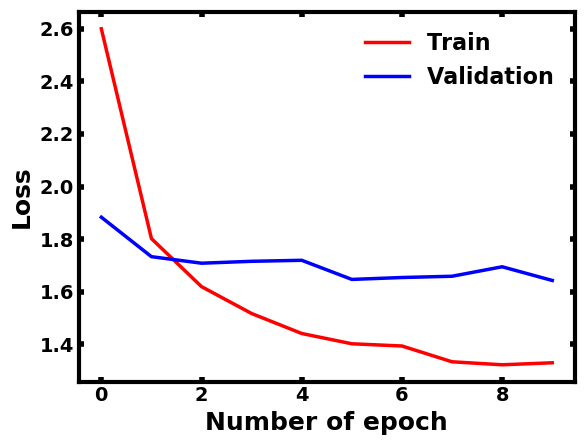

In [81]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, color='red', label= 'Train', linewidth=2.5)
plt.plot(range(len(val_losses)), val_losses, color =  'Blue', label = 'Validation', linewidth=2.5)
#plt.title('Classification loss')
plt.legend(frameon=False,prop={'weight':'bold',"size":16})
plt.xlabel('Number of epoch',fontweight='bold', fontsize=18)
plt.ylabel('Loss',fontweight='bold', fontsize=18)
#plt.title('GP Regression',fontweight='bold')
#plt.axis('square')
from matplotlib import rc

plt.rcParams['axes.linewidth'] = 3

plt.tick_params(axis="x", direction="in",width=4)
plt.tick_params(axis="y", direction="in", width=4)

rc('font', weight='bold')

plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.xticks(rotation = '0', fontsize = 14)
plt.yticks(rotation = '0', fontsize = 14)
#plt.legend(handles=h, labels=np.arange(0.9,0.85), title="Quality")
#plt.rcParams.update({'legend.fontweight':'bold'}
#plt.savefig('line_plot.pdf')
plt.savefig(r'/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/catalyst/curve_learnin/learning_cata.pdf', dpi=5000)
plt.show()

In [ ]:

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

**Save the model in my drive in order not to run it each time**

In [82]:
model_path = "/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/catalyst/pretrain_model/cata_only/"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/catalyst/pretrain_model/cata_only/tokenizer_config.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/catalyst/pretrain_model/cata_only/special_tokens_map.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/catalyst/pretrain_model/cata_only/vocab.txt',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/catalyst/pretrain_model/cata_only/added_tokens.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/catalyst/pretrain_model/cata_only/tokenizer.json')

# Test
We are evaluating the model on the validation set by checking the model's predictions for the answer's start and end indexes and comparing with the true ones.

# Ask question
We are going to use some functions from the official Evaluation Script v2.0 of SQuAD in order to test the fine-tuned model by asking some questions given a context. I have also looked at this notebook which evaluates BERT on SQuAD.

**Respectively, load the saved model**

# Data load for testing

In [4]:
from transformers import BertForQuestionAnswering, BertTokenizerFast

#Load the pretrained weights
model_path ="/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/catalyst/pretrain_model/cata_only/"
model = BertForQuestionAnswering.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

#Specify the cuda 
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

model = model.to(device)

Working on cuda:0


In [5]:
# model.config

In [6]:
# model.config_class()

In [7]:
# dir(model)


In [45]:
##data list
context = []
answerss = []
question =[]

#loop data points
def extractquestions(test):
    for trai in test:
        context.append(trai['context'])
        question.append(trai['qas'][0]['question'])

    for sample in test:
        gold_answers = []
        for ans in sample['qas'][0]['answers']:
            gold_answers.append(ans['text'])
        answerss.append(gold_answers)
        
    return context, answerss, question

#Data for testing
context, answerss, question = extractquestions(full)

In [46]:
question[0]

'What are the materials used as catalyst?'

In [47]:
#Define the metric lists
F1 = []
preci = []
recal = []

In [48]:
def get_prediction(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)

        answer_start = torch.argmax(outputs[0])  
        answer_end = torch.argmax(outputs[1]) + 1 

        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    except:
        print('no available')
        
        answer = "Nothing"

    return answer

In [49]:
def get_prediction_f1_0(context, question,f):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)
        start_logits = outputs[0]
        end_logits = outputs[1]

        def to_list(tensor):
            return tensor.detach().cpu().tolist()

        # convert our start and end logit tensors to lists
        start_logits = to_list(start_logits)[0]
        end_logits = to_list(end_logits)[0]

        # sort our start and end logits from largest to smallest, keeping track of the index
        start_idx_and_logit = sorted(enumerate(start_logits), key=lambda x: x[1], reverse=True)
        end_idx_and_logit = sorted(enumerate(end_logits), key=lambda x: x[1], reverse=True)

        start_indexes = [idx for idx, logit in start_idx_and_logit[:5]]
        end_indexes = [idx for idx, logit in end_idx_and_logit[:5]]

        # convert the token ids from a tensor to a list
        tokens = to_list(inputs['input_ids'])[0]

        # question tokens are defined as those between the CLS token (101, at position 0) and first SEP (102) token 
        question_indexes = [i+1 for i, token in enumerate(tokens[1:tokens.index(102)])]

        import collections

        # keep track of all preliminary predictions
        PrelimPrediction = collections.namedtuple( 
            "PrelimPrediction", ["start_index", "end_index", "start_logit", "end_logit"] )

        prelim_preds = []
        for start_index in start_indexes:
            for end_index in end_indexes:
                # throw out invalid predictions
                if start_index in question_indexes:
                    continue
                if end_index in question_indexes:
                    continue
                if end_index < start_index:
                    continue
                prelim_preds.append(
                    PrelimPrediction(
                        start_index = start_index,
                        end_index = end_index,
                        start_logit = start_logits[start_index],
                        end_logit = end_logits[end_index]
                    )
                )

        # sort preliminary predictions by their score
        prelim_preds = sorted(prelim_preds, key=lambda x: (x.start_logit + x.end_logit), reverse=True)

        # keep track of all best predictions
        BestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
            "BestPrediction", ["text", "start_logit", "end_logit"]
        )

        nbest = []
        nbest_text =[]
        seen_predictions = []
        print("best answers: ",f)
        for pred in prelim_preds:

            # for now we only care about the top 3 best predictions
            if len(nbest) >= f: 
                break

            # loop through predictions according to their start index
            if pred.start_index > 0: # non-null answers have start_index > 0

                text = tokenizer.convert_tokens_to_string(
                    tokenizer.convert_ids_to_tokens(
                        tokens[pred.start_index:pred.end_index+1]
                    )
                )
                # clean whitespace
                text = text.strip()
                text = " ".join(text.split())

                if text in seen_predictions:
                    continue

                # flag this text as being seen -- if we see it again, don't add it to the nbest list
                seen_predictions.append(text) 

                # add this text prediction to a pruned list of the top 5 best predictions
                nbest.append(BestPrediction(text=text, start_logit=pred.start_logit, end_logit=pred.end_logit))

        # and don't forget -- include the null answer!
        nbest.append(BestPrediction(text="", start_logit=start_logits[0], end_logit=end_logits[0]))

    except:
        print('no available')
        
        seen_predictions = ["nothings"]

    return seen_predictions

In [50]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [51]:
def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [52]:
def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

In [53]:
predic = []

In [54]:
def question_answer(context, question,answerss, f):
    prediction = get_prediction_f1_0(context,question,f)
    
    temp_pred = []
    
    temp_f1 = []
    for pre in prediction:
        
        #print(answerss, pre)

        if len(answerss) != 0:
            em_score = max((exact_match(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)

            f1_score = max((compute_f1(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)
            #print(f1_score)
            
            temp_f1.append(f1_score)
            print('i am here',temp_f1)
            
        if f1_score == 1.0:
            
            temp_pred.append(pre)
    
        else:
            em_score = 0
            f1_score = 0
            temp_f1 = [0]
            print(temp_f1)
        
    if max(temp_f1) == 1.0:
        F1.append(max(temp_f1))
        
    else:
        temp_f1 = []
        for pre in prediction:

            #print(answerss, pre)

            if len(answerss) != 0:
                em_score = max((exact_match(pre, answer)) for answer in answerss)

                f1_score = max((compute_f1(pre, answer)) for answer in answerss)
                #print(f1_score)
        
                temp_f1.append(f1_score)
                print("aaa",temp_f1)
            
            else:
                em_score = 0
                f1_score = 0
                temp_f1 = [0]
                
                print("aaa",temp_f1)
                
        F1.append(max(temp_f1))
        
    predic.append(temp_pred)

    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answerss}')
    print(f'Exact match: {em_score}')
    print(f'F1 score: {max(temp_f1)}\n')

In [55]:
for i in range(len(full)):
    print(i)
    question_answer(context[i], question[0],answerss[i], len(answerss[i]))

0
best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: ['naphtha']
True Answer: ['naphtha']
Exact match: True
F1 score: 1.0

1
best answers:  3
i am here [1.0]
i am here [1.0, 0]
[0]
i am here [0, 0]
[0]
aaa [1.0]
aaa [1.0, 0.020618556701030924]
aaa [1.0, 0.020618556701030924, 0.0273972602739726]
Question: What are the materials used as catalyst?
Prediction: ['copper', 'copper contents ( low - and medium - grade WEEE named as LGE and MGE, respectively ), were performed using micro - and lab - scale pyrolyzers. This research aimed to fundamentally study the feasibility of chemical recycling of the WEEE fractions via pyrolysis process considering molecular interactions at the interfaces of catalyst active sites and WEEE pyrolyzates which significantly influence the chemical functionality of surface intermediates and catalysis by reorganizing the pyrolyzates near catalytic active sites forming reactive surface intermediates. Hence, Al2O3, TiO2, H

best answers:  1
i am here [0]
[0]
aaa [0.021276595744680854]
Question: What are the materials used as catalyst?
Prediction: ['zeolites, base catalysts, and clays ) shows overwhelming advantages over thermal cracking, and an in - depth understanding of catalysts in several catalytic processes ( ex - situ catalysts, tandem catalysts, bi - functional catalysts, multi - modal pore catalysts, and regenerated catalysts ) is critical for efficient fuel production. Despite high - quality liquid fuels obtained, further upgrading ( filtration, hydrogenation, distillation, liquid – liquid extraction or blending with conventional fuels ) is required before their commercial application. Non - condensable gas is another co - product that can be upgraded for heat generation or as the precursor of high - value products ( ethylene, propylene, carbon nanotubes']
True Answer: ['zeolites']
Exact match: False
F1 score: 0.021276595744680854

26
best answers:  1
i am here [1.0]
Question: What are the materi

best answers:  3
i am here [1.0]
i am here [1.0, 0]
[0]
i am here [0, 0]
[0]
aaa [1.0]
aaa [1.0, 0.4]
aaa [1.0, 0.4, 0.5]
Question: What are the materials used as catalyst?
Prediction: ['copper', 'copper doped TiO2 ( Cu', 'copper doped TiO2']
True Answer: ['copper', 'TiO2', 'Cu']
Exact match: False
F1 score: 1.0

41
best answers:  3
i am here [1.0]
i am here [1.0, 0]
[0]
i am here [0, 0]
[0]
aaa [1.0]
aaa [1.0, 0.4]
aaa [1.0, 0.4, 0.5]
Question: What are the materials used as catalyst?
Prediction: ['copper', 'copper doped TiO2 ( Cu', 'copper doped TiO2']
True Answer: ['copper', 'TiO2', 'Cu']
Exact match: False
F1 score: 1.0

42
best answers:  7
i am here [1.0]
i am here [1.0, 0]
[0]
i am here [0, 1.0]
i am here [0, 1.0, 0]
[0]
i am here [0, 0]
[0]
i am here [0, 0]
[0]
i am here [0, 0]
[0]
aaa [0.6666666666666666]
aaa [0.6666666666666666, 0.047619047619047616]
aaa [0.6666666666666666, 0.047619047619047616, 1.0]
aaa [0.6666666666666666, 0.047619047619047616, 1.0, 0.04081632653061225]
aaa

best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: ['naphthalene']
True Answer: ['naphthalene']
Exact match: True
F1 score: 1.0

69
best answers:  2
i am here [1.0]
i am here [1.0, 0]
[0]
aaa [1.0]
aaa [1.0, 0.5]
Question: What are the materials used as catalyst?
Prediction: ['sulfur', 'ferrocene and sulfur']
True Answer: ['sulfur', 'ferrocene']
Exact match: False
F1 score: 1.0

70
best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: ['NiMo - assisted']
True Answer: ['NiMo-assisted']
Exact match: True
F1 score: 1.0

71
best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: ['pyridine']
True Answer: ['pyridine']
Exact match: True
F1 score: 1.0

72
best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: ['naphthalene']
True Answer: ['naphthalene']
Exact match: True
F1 score: 1.0

73
best answers:  2
i am here [1.0]
i am h

best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: ['Fe - Mn / Al2O3']
True Answer: ['Fe-Mn/Al2O3']
Exact match: True
F1 score: 1.0

99
best answers:  3
i am here [0]
[0]
i am here [0, 1.0]
i am here [0, 1.0, 1.0]
Question: What are the materials used as catalyst?
Prediction: ['chlorine, 0. 14 wt % ) obtained from pyrolysis of refuse plastic fuel was studied using iron oxide impregnated HY zeolite to produce a useful liquid product. It was found that the largest liquid fraction ( gasoline and kerosene / diesel, 66. 9 wt. % ) with very low chlorine content was achieved when using Fe', 'Fe', 'chlorine']
True Answer: ['chlorine', 'Fe', 'zeolite']
Exact match: True
F1 score: 1.0

100
best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: ['zeolite']
True Answer: ['zeolite']
Exact match: True
F1 score: 1.0

101
best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: 

best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: ['zeolite']
True Answer: ['zeolite']
Exact match: True
F1 score: 1.0

127
best answers:  2
i am here [1.0]
i am here [1.0, 0]
[0]
aaa [1.0]
aaa [1.0, 0.05714285714285715]
Question: What are the materials used as catalyst?
Prediction: ['chlorine', 'zeolite as catalyst. A low temperature ( 300°C ) dechlorination step has been carried out both with and without catalyst. It has been proved that the application of such dechlorination step gives rise to a 75wt % reduction of chlorine']
True Answer: ['chlorine', 'zeolite']
Exact match: False
F1 score: 1.0

128
best answers:  1
i am here [1.0]
Question: What are the materials used as catalyst?
Prediction: ['zeolite']
True Answer: ['zeolite']
Exact match: True
F1 score: 1.0

129
best answers:  2
i am here [1.0]
i am here [1.0, 0]
[0]
aaa [1.0]
aaa [1.0, 0.15384615384615385]
Question: What are the materials used as catalyst?
Prediction: ['naphtha', 'n

In [56]:
len(F1), len(full), len(predic)

(153, 153, 153)

In [57]:
predic

[['naphtha'],
 ['copper'],
 ['graphene'],
 ['graphene'],
 ['Zeolite'],
 ['Zeolite'],
 ['CaCO3'],
 ['sodium', 'iron'],
 ['sodium', 'iron'],
 ['iron / graphite', 'iron'],
 ['zeolite'],
 [],
 [],
 ['zeolites'],
 ['zeolites'],
 ['CaO', 'MgO'],
 ['CaO', 'MgO'],
 ['Mo / MgO', 'Fe – Mo / MgO', 'MgO', 'Mo', 'Fe', '– Mo / MgO'],
 ['Ni', 'Mo'],
 ['Ni', 'Mo'],
 ['NiFe2O4'],
 ['SiC'],
 ['SiC'],
 ['Graphite'],
 ['Ni – Mg – Al', 'Ni', 'Mg – Al'],
 [],
 ['zeolite'],
 ['Ni – Mg – Al', 'Ni', 'Mg – Al'],
 ['zeolite'],
 [],
 ['zeolite'],
 ['naphtha'],
 ['Co'],
 ['naphtha'],
 ['Co'],
 ['copper', 'Cu'],
 [],
 ['copper', 'Cu'],
 [],
 [],
 ['copper'],
 ['copper'],
 ['Ni - based', 'Ni'],
 ['chlorine', 'zeolites'],
 ['zeolite'],
 ['potassium'],
 ['potassium'],
 ['MgO'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Cu / CNS', 'Cu'],
 ['Ru / Al2O3'],
 ['iron / nickel', 'Fe / Ni', 'Fe / Ni - CeO2'],
 ['Ni / Mo / MgO', 'graphene'],
 ['Ni / Mo / MgO', 'graphene'],
 ['Fe - based', 'Mn'],
 ['Ni'],
 ['Ni - Pt / Al - Ti'],

In [60]:
import pandas as pd
dfff = pd.read_csv("/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/data_random_data_153.csv")
dfff.head()

,Unnamed: 0,DOI,Title,Abstract,Date,Journal,catalyst,reactant,Method,Product
0,0,10.1016/j.pecs.2022.101021,Pyrolysis technology for plastic waste recycli...,Discarded plastics can be converted to various...,November 2022,Progress in Energy and Combustion Science,['naphtha'],"['Discarded plastics', 'plastic waste', 'plast...","['pyrolysis', 'fine-tune efficient selective p...","['product distribution', 'feasible commercial ..."
1,1,10.1016/j.apsusc.2022.154734,Selective recycling of BTX hydrocarbons from e...,Non-catalytic and catalytic pyrolysis of two w...,15 December 2022,Applied Surface Science,"['copper', 'TiO2', 'zeolites']",['waste electrical electronic equipment'],"['Non-catalytic catalytic pyrolysis', 'pyrolys...",['selective production']
2,2,10.1016/j.joei.2022.101154,Achieving affordable and clean energy through ...,Millions of tons of waste plastic are generate...,February 2023,Journal of the Energy Institute,['graphene'],"['waste plastic', 'These waste plastics', 'The...","['conversion', 'conversion', 'plastic conversi...","['affordable clean energy', 'value-added produ..."
3,3,10.1016/j.joei.2022.101154,Achieving affordable and clean energy through ...,Millions of tons of waste plastic are generate...,February 2023,Journal of the Energy Institute,['graphene'],"['waste plastic', 'These waste plastics', 'The...","['conversion', 'conversion', 'plastic conversi...","['affordable clean energy', 'value-added produ..."
4,4,10.1016/j.eti.2022.102453,Hydrocarbons recovery through catalytic pyroly...,The overall objective of this study is to deve...,August 2022,Environmental Technology & Innovation,['Zeolite'],"['compostable waste plastics', 'unused compost...","['pyrolysis', 'catalytic pyrolysis', 'pyrolysi...",['pyrolysis oil products']


In [61]:
dfff['Predict catalyst'] = predic

In [ ]:
dff

In [19]:
#F1[15], question_answer(context[15], question[0],answerss[15])

In [20]:
sum(F1)/len(F1)

0.9353147663535648

In [ ]:
#Random data points
train = 0.9440
valid = 0.8708
test =  0.9574

full = 0.9353

In [92]:
#The 1136 points used for catalyst
#save model is cata_with_all_questions_1136
#save the learning curve learning_curve_for_cata.pdf
Train = 0.9230
Valid = 0.8690
test  = 0.8792

In [ ]:
#results for best three answer
Train = 0.9410
valid = 0.8551
test = 0.6564

In [ ]:
#Date 21-12-2022 with 5 best answer
train = 0.974
valid = 0.855
test =  0.7342

In [ ]:
Train =  0.8368
Test  =  0.8313
valid =  0.8000

In [ ]:
#Date 01/12/2022 without space all questions are answered
Train = 0.8461
Test = 0.8076
valid = 0.80

#Date 01/12/2022 with space all questions are answered
Train =  0.5853
Test  =  0.5853
Valid =  0.6088

# random data set utilized

In [11]:
import pandas as pd
df =  pd.read_csv(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/data_making_qna/random_files.csv")

df.head()

,Unnamed: 0,DOI,Title,Abstract,Date,Journal
0,0,10.1016/j.psep.2022.11.027,Optimal sorting and recycling of plastic waste...,This work suggests an optimal strategy to sort...,January 2023,Process Safety and Environmental Protection
1,1,10.1016/j.ecolecon.2022.107535,The effects of the containers and packaging re...,This study investigates the impact of a policy...,November 2022,Ecological Economics
2,2,10.1016/j.fuproc.2022.107474,Towards high-quality petrochemical feedstocks ...,Advanced plastic waste recycling via pyrolysis...,15 December 2022,Fuel Processing Technology
3,3,10.1016/j.jece.2022.108332,Morpho-structural and thermo-mechanical charac...,"In this work, a complete sorting and character...",October 2022,Journal of Environmental Chemical Engineering
4,4,10.1016/j.clce.2022.100064,Recycling of plastic wastes into alternative f...,Traditional methods of disposing and storing p...,December 2022,Cleaner Chemical Engineering


In [18]:
date = []
for i in range(len(df)):
    date.append(int(df.Date[i][-4:]))
    #print(int(df.Date[i][-4:]))

In [22]:
pd.Series(date).value_counts()

2022    176
2021     52
2023     51
2020     20
2019     12
2018      5
3         2
dtype: int64

In [23]:
PUSHILSER = []
for i in range(len(df)):
    PUSHILSER.append(df.Journal[i])

In [24]:
pd.Series(PUSHILSER).value_counts()

Waste Management                             33
Journal of Cleaner Production                29
Resources, Conservation and Recycling        28
Science of The Total Environment             18
Construction and Building Materials          16
                                             ..
Additives for Polymers                        1
Resources, Environment and Sustainability     1
Water Science and Engineering                 1
Materials Today Chemistry                     1
Journal of Chromatography A                   1
Length: 105, dtype: int64

In [32]:
from transformers import BertForQuestionAnswering, BertTokenizerFast

#Load the pretrained weights
model_path ="/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/catalyst/pretrain_model/cata_only/"
model = BertForQuestionAnswering.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

#Specify the cuda 
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

model = model.to(device)

Working on cuda:0


In [33]:
def get_prediction_f1_0(context, question,f):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)
        start_logits = outputs[0]
        end_logits = outputs[1]

        def to_list(tensor):
            return tensor.detach().cpu().tolist()

        # convert our start and end logit tensors to lists
        start_logits = to_list(start_logits)[0]
        end_logits = to_list(end_logits)[0]

        # sort our start and end logits from largest to smallest, keeping track of the index
        start_idx_and_logit = sorted(enumerate(start_logits), key=lambda x: x[1], reverse=True)
        end_idx_and_logit = sorted(enumerate(end_logits), key=lambda x: x[1], reverse=True)

        start_indexes = [idx for idx, logit in start_idx_and_logit[:5]]
        end_indexes = [idx for idx, logit in end_idx_and_logit[:5]]

        # convert the token ids from a tensor to a list
        tokens = to_list(inputs['input_ids'])[0]

        # question tokens are defined as those between the CLS token (101, at position 0) and first SEP (102) token 
        question_indexes = [i+1 for i, token in enumerate(tokens[1:tokens.index(102)])]

        import collections

        # keep track of all preliminary predictions
        PrelimPrediction = collections.namedtuple( 
            "PrelimPrediction", ["start_index", "end_index", "start_logit", "end_logit"] )

        prelim_preds = []
        for start_index in start_indexes:
            for end_index in end_indexes:
                # throw out invalid predictions
                if start_index in question_indexes:
                    continue
                if end_index in question_indexes:
                    continue
                if end_index < start_index:
                    continue
                prelim_preds.append(
                    PrelimPrediction(
                        start_index = start_index,
                        end_index = end_index,
                        start_logit = start_logits[start_index],
                        end_logit = end_logits[end_index]
                    )
                )

        # sort preliminary predictions by their score
        prelim_preds = sorted(prelim_preds, key=lambda x: (x.start_logit + x.end_logit), reverse=True)

        # keep track of all best predictions
        BestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
            "BestPrediction", ["text", "start_logit", "end_logit"]
        )

        nbest = []
        nbest_text =[]
        seen_predictions = []
        print("best answers: ",f)
        for pred in prelim_preds:

            # for now we only care about the top 3 best predictions
            if len(nbest) >= f: 
                break

            # loop through predictions according to their start index
            if pred.start_index > 0: # non-null answers have start_index > 0

                text = tokenizer.convert_tokens_to_string(
                    tokenizer.convert_ids_to_tokens(
                        tokens[pred.start_index:pred.end_index+1]
                    )
                )
                # clean whitespace
                text = text.strip()
                text = " ".join(text.split())

                if text in seen_predictions:
                    continue

                # flag this text as being seen -- if we see it again, don't add it to the nbest list
                seen_predictions.append(text) 

                # add this text prediction to a pruned list of the top 5 best predictions
                nbest.append(BestPrediction(text=text, start_logit=pred.start_logit, end_logit=pred.end_logit))

        # and don't forget -- include the null answer!
        nbest.append(BestPrediction(text="", start_logit=start_logits[0], end_logit=end_logits[0]))

    except:
        print('no available')
        
        seen_predictions = ["nothings"]

    return seen_predictions

In [36]:
def get_prediction(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)

        answer_start = torch.argmax(outputs[0])  
        answer_end = torch.argmax(outputs[1]) + 1 

        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    except:
        print('no available')
        
        answer = "Nothing"

    return answer

In [34]:
questions = ['What are the materials used as catalyst?']

In [40]:
df.Abstract[0]

'This work suggests an optimal strategy to sort and recycle plastic waste as a renewable energy resource with maximizing economic feasibility and mitigating environmental pollution. To derive the optimal sorting and recycling strategies of plastic waste, a novel optimization model is developed; it calculates the overall profit by subtracting the profit of recycling plastic from the total annualized cost. Then the model is used to identify the optimal strategy to sort and recycle plastic waste as a renewable energy resource in mixed-integer nonlinear programming that maximizes the overall profit. In the derived optimal sorting and recycling strategy, high-density polyethylene is recycled to produce downgrade plastic; low-density polyethylene, polypropylene, and polystyrene are recycled as pyrolysis oil; and polyethylene terephthalate is recycled to produce refuse plastic fuel. The derived optimal case can significantly increase the overall profit by about 3,137% (i.e., 35 US$/1 kg of re

In [49]:
#All chemical entities of catalyst
df_cat =  pd.read_csv(r'/home/user3/Documents/avan_phd/objective_escape/catalys_entit_final.csv')
df_cat =  df_cat.drop(['Unnamed: 0', 'frequency', 'Unnamed: 3', '7738'], axis= 1)
df_cat.head(2)

,section name
0,Cu
1,Ni


In [50]:
#The exact catalyst entities
cata = list(df_cat['section name'])
print("Total unique entries of catalyst:",len(cata))

Total unique entries of catalyst: 807


In [52]:
'Al2O3'.lower()

'al2o3'

In [57]:
#BART1 environment
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
#Import nltk, download repositary for tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/user3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
#Imported chemical entity extraction library
import chemdataextractor
from chemdataextractor import Document

import spacy
  
# Load English tokenizer, tagger, 
# parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

from spacy import displacy

In [65]:
#Filter all non-catalyst entities
def catalystentities(text):
    name_catalyst =  []
    comp = []
    if ('catalyst' in text.lower()) or ('catalysts' in text.lower()):
        cataa = []
        doc = Document(text)
        ent = doc.cems
        for i in range(len(ent)):
            comp.append(ent[i].text)
            doc = nlp(text)
            for chunk in doc.noun_chunks:
                for wrd in word_tokenize(chunk.text):
                    for cat in comp:
                        if (cat in cata):
                            if cat in wrd:
                                cataa.append(wrd)                            
    else:
        cataa = []
                                
    
    name_catalyst.append(cataa)                           
    return cataa

In [66]:
df['catalyst'] = df['Abstract'].apply(catalystentities)

In [69]:
indexx = []
for i, cataa in enumerate(df['catalyst']):
    if len(cataa) != 0:
        print(cataa)
        indexx.append(i)
        

['naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha', 'naphtha']
['TiO2', 'TiO2', 'zeolites', 'TiO2', 'zeolites', 'TiO2', 'zeolites', 'copper', 'TiO2', 'zeolites', 'copper', 'TiO2', 'zeolites', 'copper', 'TiO2', 'zeolites']
['graphene', 'graphene']
['Co', 'Co/MnO', 'Co/MnO', 'Co', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co', 'Co', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co', 'Co', 'Co', 'Co/MnO', 'Co/MnO', 'Co/MnO', 'Co/MnO',

In [70]:
indexx

[16, 40, 148, 179, 210, 225, 232]

In [73]:
aa = df.iloc[indexx].reset_index(drop = True)

In [75]:
aa

,Unnamed: 0,DOI,Title,Abstract,Date,Journal,catalyst
0,16,10.1016/j.pecs.2022.101021,Pyrolysis technology for plastic waste recycli...,Discarded plastics can be converted to various...,November 2022,Progress in Energy and Combustion Science,"[naphtha, naphtha, naphtha, naphtha, naphtha, ..."
1,40,10.1016/j.apsusc.2022.154734,Selective recycling of BTX hydrocarbons from e...,Non-catalytic and catalytic pyrolysis of two w...,15 December 2022,Applied Surface Science,"[TiO2, TiO2, zeolites, TiO2, zeolites, TiO2, z..."
2,148,10.1016/j.joei.2022.101154,Achieving affordable and clean energy through ...,Millions of tons of waste plastic are generate...,February 2023,Journal of the Energy Institute,"[graphene, graphene]"
3,179,10.1016/j.apcatb.2022.122271,Multi-scale designed Co x Mn3–x O4 spinels: Sm...,"In this work, multiscale designed 3-dimensiona...",5 May 2023,Applied Catalysis B: Environmental,"[Co, Co/MnO, Co/MnO, Co, Co/MnO, Co/MnO, Co/Mn..."
4,210,10.1016/j.eti.2022.102453,Hydrocarbons recovery through catalytic pyroly...,The overall objective of this study is to deve...,August 2022,Environmental Technology & Innovation,"[Zeolite, Zeolite, Zeolite, Zeolite, Zeolite, ..."
5,225,10.1016/j.jhazmat.2022.130609,In-situ exsolution of Fe-Ni alloy catalysts fo...,The management of plastic wastes has become an...,5 March 2023,Journal of Hazardous Materials,"[Fe-Ni, Ni, Ni, Fe-Ni, Fe-Ni, Fe-Ni, Ni, Ni, F..."
6,232,10.1016/j.psep.2022.09.072,A novel resource conversion strategy of waste ...,With the rapid development of e-commerce and e...,December 2022,Process Safety and Environmental Protection,"[CaCO3, CaCO3, RCaCO3, CaCO3, CaCO3, RCaCO3, C..."


In [77]:
answerss = []
for i in range(len(aa)):
    if ('catalyst' in aa.Abstract[i].lower()) or ('catalysts' in aa.Abstract[i].lower()):

        #print(aa.Abstract[i])
        print(get_prediction(aa.Abstract[i], questions[0]), "\n")

naphtha 

copper 

graphene 

Co x Mn3 – x O4 spinel smart pre - catalysts that can self - convert into the targeted active site - rich Co / MnO 

Zeolite 

Fe - Ni 

CaCO3 



In [78]:
cataa

[]